## Introduction

Cyclistic is a successful Chicago based bike-sharing program launched in 2016, it has grown to a network of 5,824 geotracked bicycles spanning 692 stations across the city. Bikes can be picked up at one station and dropped off at another station anytime. There are multiple bike types to choose from, classic bicycles, electric bikes, and docked bikes.    

When using bikeshare there are multiple pricing plans, including single-ride passes, full-day passes, and annual memberships. Customers who purchase single-ride or full-day passes are referred to as casual riders. Customers who purchase annual memberships are Cyclistic members.    

Initially, Cyclistic’s marketing approach relied of general awareness and appealing to broad customer segments, however the team desires to develop a marketing approach that focuses on converting casual riders into users of the annual membership, as Cyclistic’s financial analysts have concluded that annual members are much more profitable.

### Business Task

The purpose of this report is to identify any differences between casual users and annual members of the Cyclistic Bikeshare application. If there are meaningful differences, can they be leveraged into a marketing campaign to convert more casual users (those who used single-ride passes or full-day passes) into users who are subsribed to the annual membership? This analysis will inform decisions on the future marketing program as the success of the Cycistic Bikesharing program depends on maximizing the number of annual memberships.

### Data

Lyft Bikes and Scooters, LLC (“Bikeshare”) operates the City of Chicago’s (“City”) Divvy bicycle sharing service, and allows the data to be copied, modified and analyzed nonexclusively and royalty free. The data license agreement can be viewed here:  
https://ride.divvybikes.com/data-license-agreement  

The data used in this analysis are a series of .csv files consisting of observations of individual rides in the Chicago area aggregated by month and generated by Amazon Web Services, which suggests the data is credible and reliable for the scope of this analysis.  

Each observation contains the following variables:  
- __ride_id__ : unique Ride ID for each observation
- __rideable_type__ : classic, docked, or electric bicycle
- __started_at__ : datetime at the beginning
- __ended_at__ : datetime at the end
- __start_station_name__ : station name where bike was picked up
- __start_station_id__ : station id where bike was picked up
- __end_station_name__ : station name where bike was dropped off
- __end_station_id__ : station id where bike was dropped off
- __start_lat__ : starting latitude where bike was picked up
- __start_lng__ : starting longitude where bike was picked up
- __end_lat__ : ending latitude where bike was dropped off
- __end_lng__ : ending latitude where bike was dropped off
- __member_casual__ : casual riders (those who used single-ride passes or full-day passes) member rides (subscribed to annual membership)


### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
import time
# for calcuating minimum ride distance between two station's lat/longs
from math import radians, cos, sin, asin, sqrt

In [2]:
# functions written specifically to analyze cyclistic bike share data
from cyclistic_analysis_functions import *

### Data Cleaning and Preprocessing

In [3]:
# Bikeshare Data from January 2021 (202101) - January 2022 (202201)
date_indices = [
    '202101', '202102', '202103', '202104', '202105', '202106',
    '202107', '202108', '202109', '202110', '202111', '202112', '202201']

# DataFrame of all Bikeshare oberservations from Jan 2021 to Jan 2022
df = generate_data(date_indices)

In [4]:
df.shape

(5698833, 13)

The raw data contains 5,698,833 indivual observations with 13 variables from the start of January 2021 to the ed of January 2022

In [5]:
for column in df.columns:
    print(f'{column}:')
    print(f'{percent_null(df, column)} %')

ride_id:
0.0 %
rideable_type:
0.0 %
started_at:
0.0 %
ended_at:
0.0 %
start_station_name:
12.407 %
start_station_id:
12.407 %
end_station_name:
13.285 %
end_station_id:
13.285 %
start_lat:
0.0 %
start_lng:
0.0 %
end_lat:
0.085 %
end_lng:
0.085 %
member_casual:
0.0 %


Among all the data, 12-13% of them have missing values for  `start_station_name,` `start_station_id,` `end_station_name,` and `end_station_id.` Those rows of observations are still included, however because they are not essential for the analysis, but do provide auxillary context. In addition, 0.085% of the observations having missing values for `start_lat,` `start_lng,` `end_lat,` and `end_lng.` These variables are used for calculating the minimum `distance` possibly traveled (if they bike straight from the beginning latitude and longitude to the end latitude and longitude). When calculating summary statistics related to distance traveled the null values will be ignored, which does affect the data, however a minimal amount (only 0.085%).

In [6]:
# generating columns of new variables using the raw data
# distance_miles, travel_time, tr_time_nano, weekday_num
df = generate_columns_pack(df)

4 new variables are generated from the raw data:  
- __distance_miles__  : calculated from start_lat, start_lng, end_lat, end_long. Records the minimum possible distance traveled (in miles) from the beginning to the end of the ride.
- __tr_time_nano__  : calculated from started_at and ended_at. Records the time passed from the beginning to the end of the session. (converted into a nanoseconds integer for easy arithmatic when calculating various summary statistics.
- __travel_time__ : calculated from tr_time_nano. Records the time passed from the beginning to the end of the session, then converted into a readable string format to be easily interpreted. 
- __weekday_num__ : calculated from started_at. Records the day of the week for each observation. (Mon: 0, Tue: 1, Wed: 2, Thur: 3, Fri: 4, Sat: 5, Sun: 6)

See cyclistic_customer_report_2021_2022.py for more details on how specifically the new columns are generated. Especially under `generate_columns_pack()`

### Errors
There are some errors in the data that were uncovered during analysis.
- __Non-events:__ 1.39% observations are considered `non_events,` there are sessions that started and ended at the same station and lasted less than 2 mins. The implication here is that these sessions aren't useful for the scope of this analysis thus skewing the data and detracting from the business task which is to find the characteristics of our target market segment (casual and member riders).
- __Negative time traveled:__ Upon analyzing `travel_times,` it was discover that 147 observations (only 0.0026% total) had negative travel times, meaning `started_at` is a later datetime than `ended_at.` This is an error that needs to be filtered out, and since so few errors of this kind occur, it is okay to remove these rows.
- __Null distances:__ Due to there being some values missing starting and ending latitudes and longitudes, an equal amount will have a NaN in the `distance_miles` column. Since there are 0.085% instances of this occuring, these observations can be filtered out. 
- __Outliers:__ There were 2 suspicious observations, once on 2021-11-09 (outlier A) and another at 2022-01-14 (outlier B). When considering the distance between the start and end coordinates, and the time travel time, it would be impossible to ride at those speeds. For outlier A roungly 71 miles in 55 mins and for outlier B 739 miles in 2 mins. These will be removed from the final analysis.

In [7]:
df = clean_data(df)

After cleaning the data of the errors and outliers above, 84289 (0.015%) were remove leaving 5614544 observations (99.985%). Overall, this will improve the quality of the analysis without significantly compromising the data.

_For more information of how exacly new data columns where generated or how the data was cleaned see `cyclistic_analysis_functions.py`_

### Generating Summary Statistics
A dictionary of summary statistics is created with `generate_overall_summary_dict()`   
The statistics dictionary are grouped into three categories `cnt_pcnt_stats,` `wkd_dict,` and `percentile_dict:`

`cnt_pcnt_stats` involves the counts and percents of the subgroups in relation to the whole dataset.  
`wkd_dict` is a dictionary of statistics broken down by weekday, such as the count of that day overall, and broken down by rideable type, as well as means and standard deviations for time and distance traveled. 
`percentile_dict` involves the percentiles of time and distance traveled for each subgroup, in addition to its respective max, mean and st dev. 
The list of percentiles (1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99) were calculated to provide a robust look at the distribution of travel distances and times.   


Those stats are calculated on 5 different subgroups of the data filtered based on certain criteria `overall,` `member,` `leisure,` and `non_leisure,:`  

`casual` and `member` depend on whether the observation was from a casual rider or member user.   
`leisure` riders being those who started at the same station that they finished at and biked for over 10 mins. This implies that it is likely that those riders are not using the app to commute, which is considered a different market segment and filters out `non_events` which are sessions that last less than 2 mins, and also start at the same station they finished at. This isn't to imply that there aren't users that who are biking leisurely who finished their session at a station different from where it started, but filtering the data via this pure definition can provide context for further analysis (only 3.87% of all users match the criteria).  
Finally statistics are made among all the users, which is labeled as `overall.`

In [8]:
# generate dictionary of summary statistics over all the data (jan 1, 2021 - jan 31, 2022)
summary_dict = generate_overall_summary_dict(df, '2021_2022')

### Analysis

Aggregated Over the Year there were 5595063 rides overall, 2529005 (45.2%) of them were casual users and 3066058 (54.8%) of them were member users, suggesting there is a large segment of the market that can be converted to annual members.  

Casual riders overall go on longer rides than member riders, both in terms of time passed during the session and distance traveled between starting and finishing coordinates.  Casual mean time is 30:33 mins, while member mean time is 13:30 mins. Also, casual mean distance is 1.42 miles, while member mean distance is 1.33 miles.  

There is an enormous discrepancy between maximum time traveled for casual users (38 days 20:24:09) and maximum time traveled for members (1 day 0:59:56), yet a less pronounced difference between casual max distance travel (21.0 miles) and member max distance traveled (19.9 miles). This may suggest that there are casual ride times that are skewing the mean travel time, however when plotting the distribution of percentiles, casual users have consistently longer travel times. In addition, there are at least 1129 casual rides that are longer than the max travel time for members, and 175 rides over 10 days. This suggests that the fat tail at the end of the casual travel ride time distribution may not be an anomaly, thus must be considered.
The pattern of casual users going on longer rides than member users is consistent over months and throughout the week.  

On a weekly basis casual users and member users exhibit different behavior patterns. Casual riders use Bikeshare considerably more during the weekend, especially on Saturdays, while members use Bikeshare more often during the week and less on the weekend. This would suggest generally that there are different uses for Bikeshare for casual users and members. Members perhaps using it to commute, while casual riders are enjoying Bikeshare for more leisureful activities.   

An additional observation is that casual users are exclusively the ones who used docked bikes. Only a single use of a docked bike was by an annual member out of the 309947 total instances where a docked bike was used. This furthers the notion that existing members are using Bikeshare for commuting, thus being more inclined to opt for a bike that they can take and drop off their bicycle as close as possible to their destination. This contrasts with a casual user who is in less of a hurry and more willing to use a docked bike, which needs to be picked up and dropped off in at a central location, as opposed to a specific destination. This behavior in casual users is supported by the aforementioned fact that they use Bikeshare longer than members, once again suggesting a different use.  

Finally, there is a trend over the year where there are noticeably more riders, (both casual and member users) in the months from June to September. In addition, from June to October, there is an uptrend in rides on Friday, Saturday and Sunday. This suggests that during the warmer months, more Bikeshare users are riding for pleasure, as their mean ride times and distances are longer for those months.

_For deeper more comprehensive analysis see notebooks `aggregated_analysis` and `monthly_analysis`_

### Visualizations

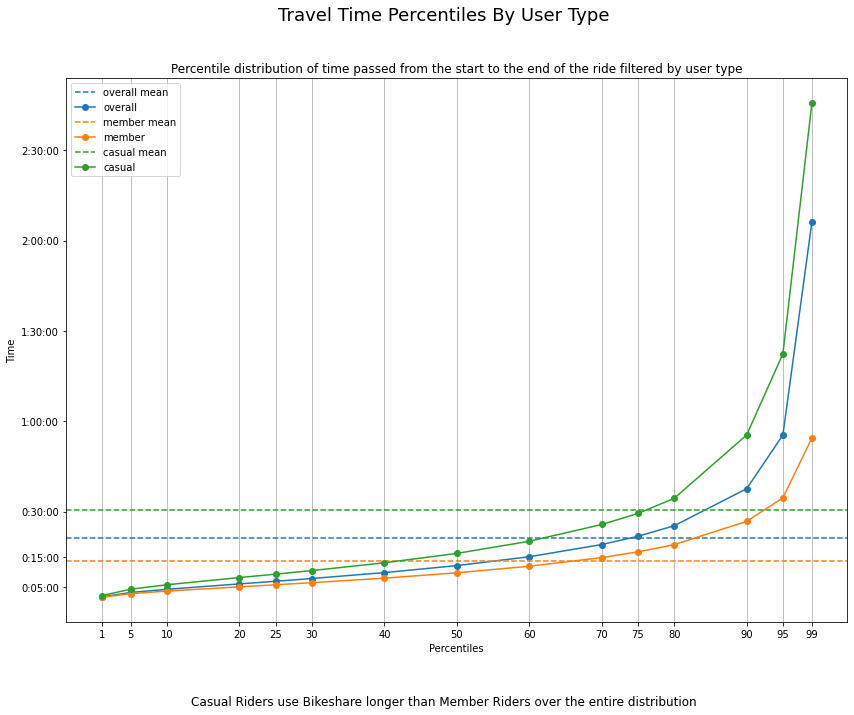

In [12]:
plot_travel_time_percentiles(summary_dict)

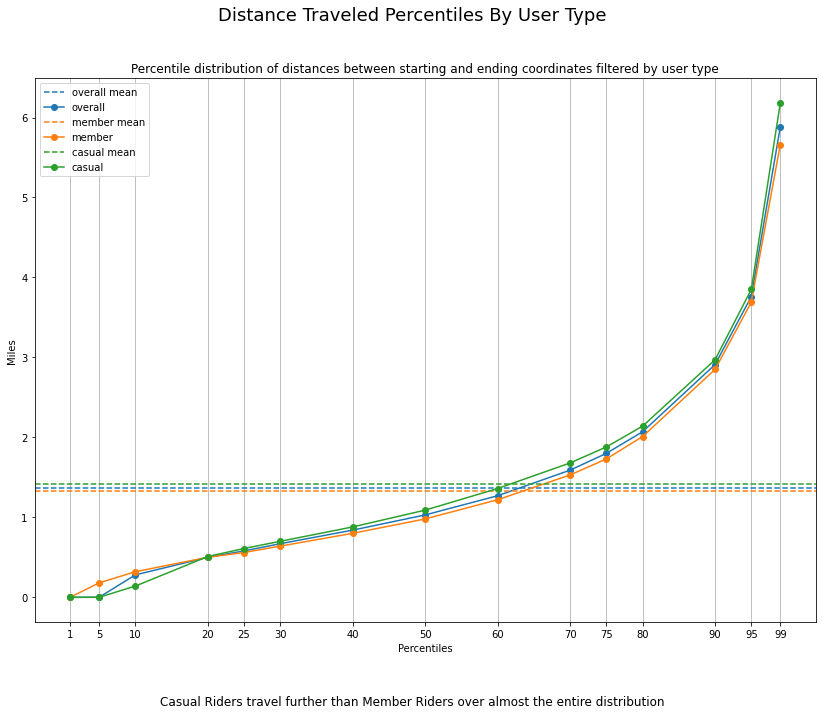

In [13]:
plot_distance_percentiles(summary_dict)

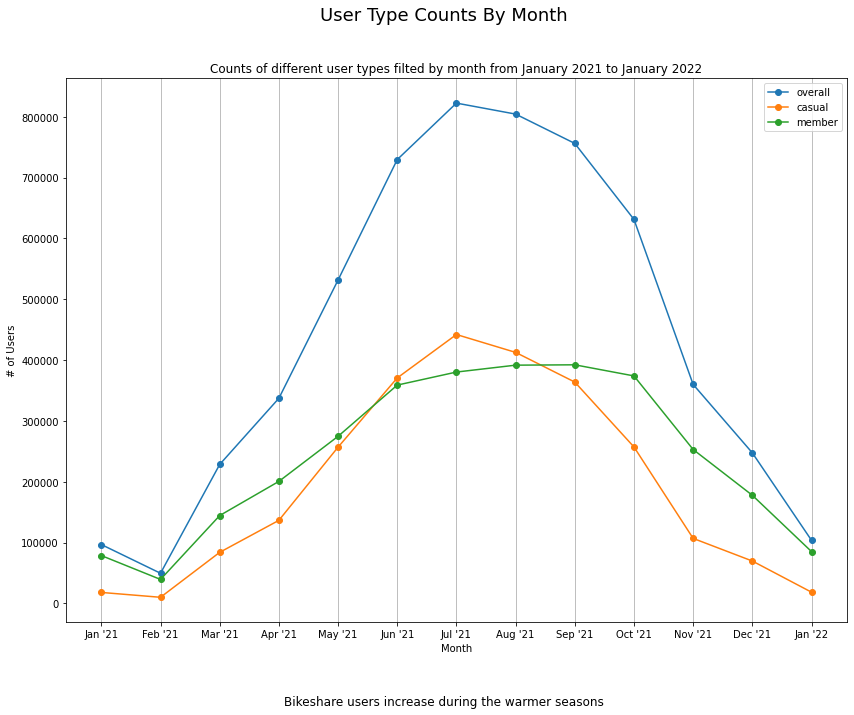

In [14]:
month_counts = pd.read_csv(r'data/user_type_counts_by_month.csv').to_dict()
plot_usertype_count_month(month_counts)

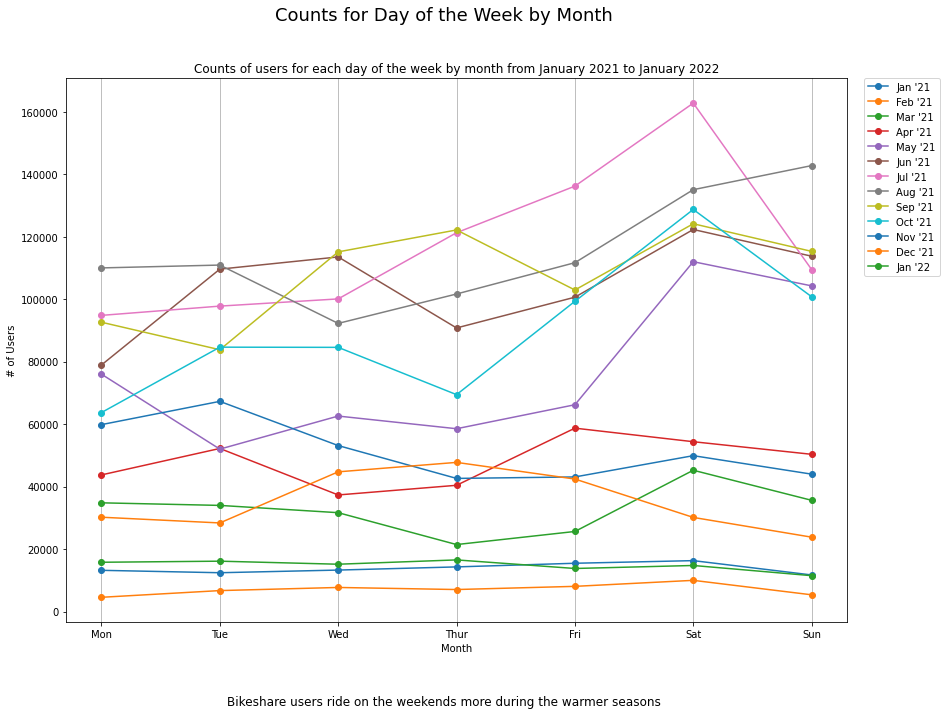

In [15]:
weekday_counts_by_month_df = pd.read_csv(r'data\weekday_counts_by_month.csv').to_dict()
weekday_counts_by_month = {}
for item in weekday_counts_by_month_df:
    weekday_counts_by_month[item] = [weekday_counts_by_month_df[item][i] for i in weekday_counts_by_month_df[item]]

plot_weekday_count_month(weekday_counts_by_month)

### Recommendations

With the goal of marketing strategy to maximize the number of annual memberships, by converting casual riders into members, the differences in behaviors between the two groups can be leveraged into an effective advertisement campaign. Here are a couple of recommendations for how to proceed. 

First, a successful marketing strategy should emphasize the advantages the membership provides for those who are using Bikeshare for pleasure, exercise and leisure. The convenience of going on a bike ride almost anywhere in the city, without having to own a bike. In addition, there is a potential cost benefit for using the Bikeshare membership as casual riders tend to go on longer rides, which is charged at a time-based rate. Especially for riders who are using the app longer than 12 hours.  

Second, an effective advertisement campaign should incorporate the fact that casual riders ride on the weekend more often than on the weekday, a behavior distinct from current member users. Perhaps introducing a feature, if one does not already exist that allows for bikes to be reserved ahead of time. This new feature could be accompanied by promoting this new feature particularly in the possibility that there can be competition for bikes in popular locations around the city and one can plan their weekend by ensuring they have a bike available.  

Lastly, the uptrend in Bikeshare usage during the warmer months should be noted when considering the timing of the advertisement campaign. Marketing resources should be used during a period where they are the most impactful, which is likely during the warmer seasons. This also can provide context for a campaign that is promoting the use to Bikeshare for leisureful weekend trips and encourage the audience to go for a bike ride right now, not in a couple of months when the weather is more amenable.  

 If further market research were to be conducted, it would be advantageous to better understand how riders use Bikeshare. This could be done by administering a customer survey on why they use Bikeshare and for what purposes. For example, riding for pleasure, to get some exercise, convenient transportation on a day trip, or to commute. The survey could also investigate aspects to Bikeshare that users would like improved, or new features they would enjoy seeing.  
 
Finally, further market research could be done to measure how different bike types, (classic, docked, and electric) impact Bikeshare usage in various locations, granted that docked bikes are exclusively used by casual riders and not by members. 